In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('course_lead_scoring.csv')

In [11]:
df.isnull().any()

lead_source                 False
industry                    False
number_of_courses_viewed    False
annual_income               False
employment_status           False
location                    False
interaction_count           False
lead_score                  False
converted                   False
dtype: bool

In [4]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
df.head(5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [9]:
df['industry'].unique()

array(['NA', 'retail', 'healthcare', 'education', 'manufacturing',
       'technology', 'other', 'finance'], dtype=object)

In [8]:
for n in categorical:
    df[n] = df[n].fillna('NA')

In [10]:
for n in numerical:
    df[n] = df[n].fillna(0.0)

In [ ]:
# Split the data
# Split your data in train/val/test sets with 60%/20%/20% distribution.
# Use Scikit-Learn for that (the train_test_split function) and set the seed to 1.
# Make sure that the target value y is not in your dataframe.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [14]:
len(df_train_full), len(df_test)

(1169, 293)

In [15]:
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [16]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
y_train = df_train.converted.values
y_val = df_val.converted.values

In [36]:
del df_train['converted']
del df_val['converted']

In [ ]:
#Question 1: ROC AUC feature importance
#ROC AUC could also be used to evaluate feature importance of numerical variables.

#Let's do that

#For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
#Use the training dataset for that
#If your AUC is < 0.5, invert this variable by putting "-" in front

#(e.g. -df_train['balance'])

#AUC can go below 0.5 if the variable is negatively correlated with the target variable. 
#You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [32]:
from sklearn.metrics import roc_auc_score

In [34]:
for numerical_feature in numerical:
    auc = roc_auc_score(y_train, df_train[numerical_feature])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[numerical_feature])
    print(f"{numerical_feature:}, AUC: {auc:.4f}")

number_of_courses_viewed, AUC: 0.7636
annual_income, AUC: 0.5520
interaction_count, AUC: 0.7383
lead_score, AUC: 0.6145


In [ ]:
# Question 2: Training the model
# Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

# LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)


In [39]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [50]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [56]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [57]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [59]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
result = auc(fpr, tpr)
print(f"The area under the curve is AUC: {result:.3f}")

The area under the curve is AUC: 0.817


In [ ]:
# Question 3: Precision and Recall
# Now let's compute precision and recall for our model.

# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
# For each threshold, compute precision and recall
# Plot them

In [62]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [63]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

Text(0, 0.5, 'Score')

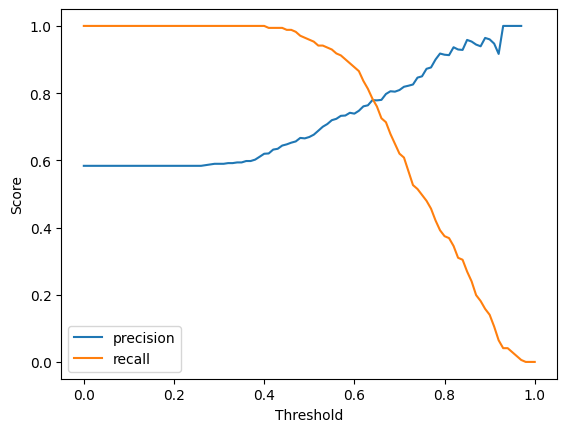

In [64]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")